Extracting Launches: 100%|██████████| 143/143 [00:13<00:00, 10.50it/s]


Excel Report Saved to: /Users/user/xSBR_Strategic_Report.xlsx


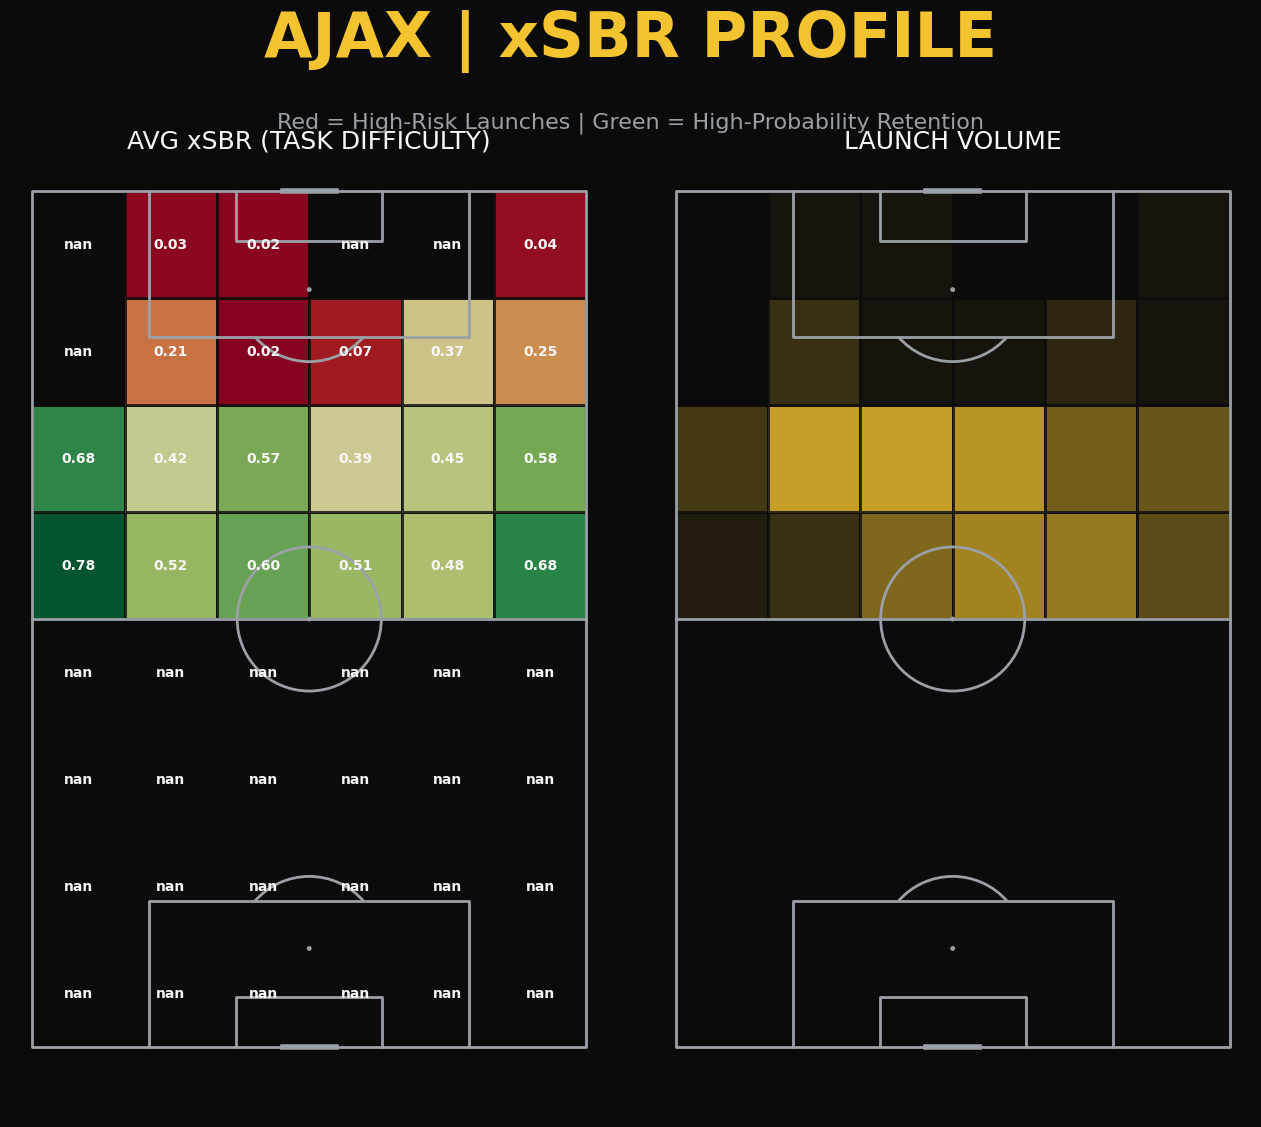

Extracting Launches: 100%|██████████| 143/143 [00:19<00:00,  7.47it/s]


ValueError: Length of values (2) does not match length of index (6501)

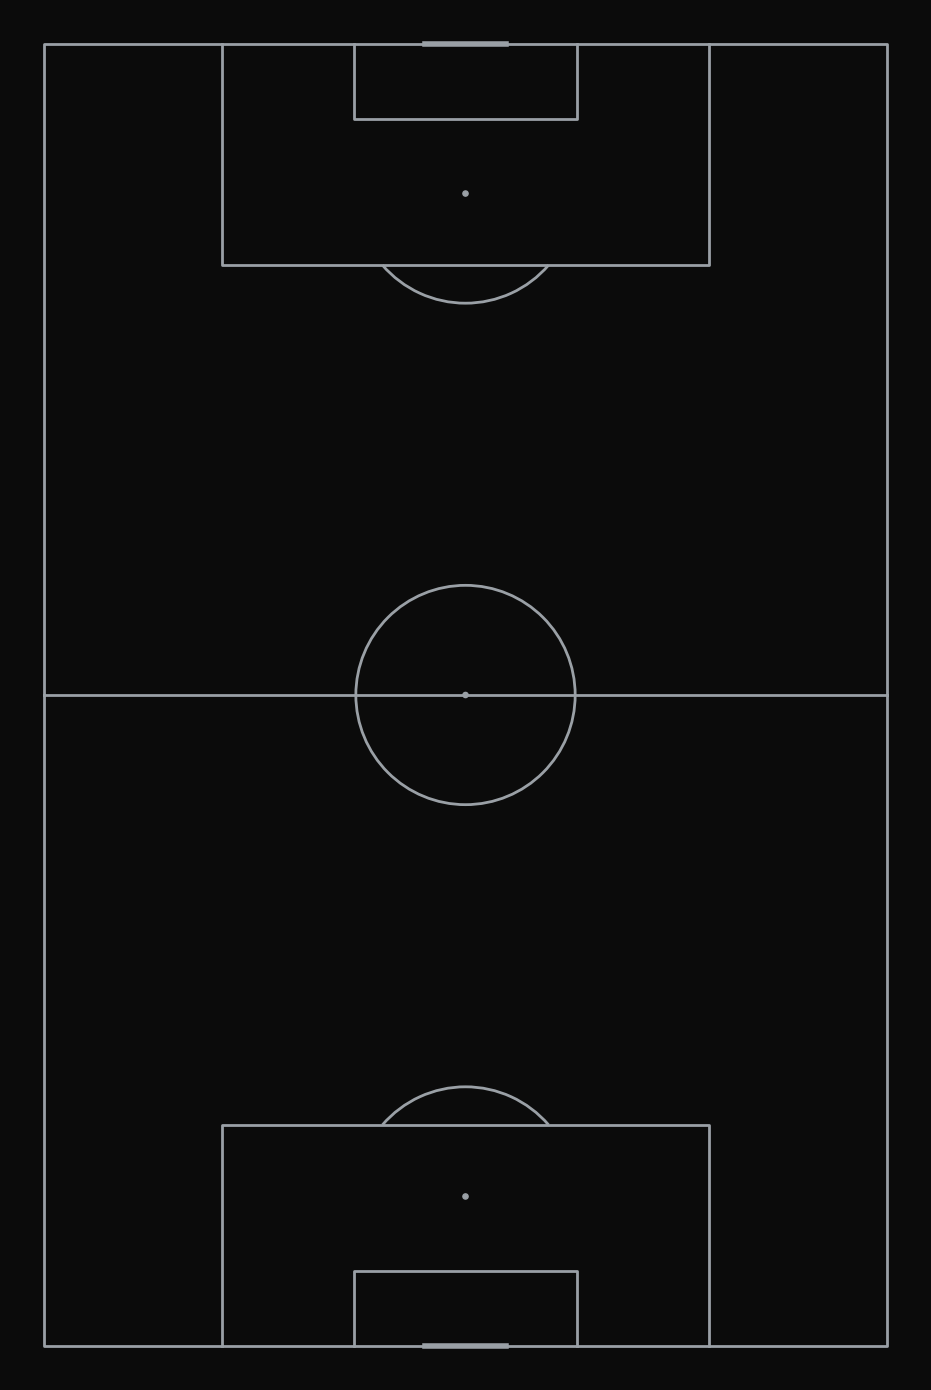

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from mplsoccer import VerticalPitch

# --- 1. CONFIGURATION & COLORS ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/')
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
OUTPUT_EXCEL = Path(r'/Users/user/xSBR_Strategic_Report.xlsx')

COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71',
    'background': '#0e1117'
}

# --- 2. DATA EXTRACTION ---
def extract_launch_data(folder_path, mapping_path):
    team_map = {}
    if mapping_path.exists():
        map_df = pd.read_csv(mapping_path)
        # Assuming typical Opta mapping structure
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    all_rows = []
    json_files = list(folder_path.glob('*.json'))
    
    for file_path in tqdm(json_files, desc="Extracting Launches"):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            events = pd.DataFrame(data.get('event', []))
            events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
        except: continue

        # Filter for Long Balls/Launches (Qual 157)
        launches = events[(events['typeId'] == 1) & events['qualifier'].apply(
            lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False
        )]
        
        for idx, row in launches.iterrows():
            # Check retention outcome (5-second window)
            window = events.iloc[idx + 1 : idx + 8]
            window = window[(window['timeStamp'] - row['timeStamp']).dt.total_seconds() <= 5.0]
            outcome = 1 if any(window['contestantId'] == row['contestantId']) else 0

            try:
                # Opta coordinates for end position (Qual 140/141)
                ex = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 140), float(row.get('x', 0)) + 45)
                ey = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 141), float(row.get('y', 50)))
                
                all_rows.append({
                    'team_name': team_map.get(row['contestantId'], row['contestantId']),
                    'outcome': outcome,
                    'start_x': float(row.get('x', 0)), 
                    'start_y': float(row.get('y', 0)),
                    'end_x': float(ex),
                    'end_y': float(ey),
                    'chaos': len(window)
                })
            except: continue
                
    return pd.DataFrame(all_rows)

# --- 3. xSBR MODELING ---
def run_xsbr_model(df):
    features = ['start_x', 'start_y', 'end_x', 'end_y', 'chaos']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    X, y = df[features], df['outcome']
    model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    model.fit(X, y)
    df['xSBR'] = model.predict_proba(X)[:, 1]
    return df

# --- 4. DOMINANCE VISUALIZATION ---
def plot_xsbr_dominance_map(df, bins=(8, 6), min_launches=3):
    """
    Corrected map using mplsoccer binnumber to prevent IndexError.
    """
    pitch = VerticalPitch(pitch_type='opta', line_color=COLORS['grey'], 
                          pitch_color=COLORS['black'], line_zorder=3)
    fig, ax = pitch.draw(figsize=(10, 14))
    fig.set_facecolor(COLORS['black'])

    # 1. Get pitch bin numbers for each event
    # This is crucial: it aligns our data exactly with the heatmap grid
    bin_stats_raw = pitch.bin_statistic(df.end_x, df.end_y, statistic='count', bins=bins)
    df['bin_idx'] = bin_stats_raw['binnumber']

    # 2. Find best team per bin based on xSBR
    bin_stats = df.groupby(['bin_idx', 'team_name']).agg(
        avg_xsbr=('xSBR', 'mean'),
        count=('xSBR', 'count')
    ).reset_index()

    # Filter for volume
    bin_stats = bin_stats[bin_stats['count'] >= min_launches]
    
    if bin_stats.empty:
        print("No data meets the minimum launch threshold.")
        return

    best_teams = bin_stats.loc[bin_stats.groupby('bin_idx')['avg_xsbr'].idxmax()]

    # 3. Create empty grids for labels and colors (matching pitch shape)
    # Note: pitch.bin_statistic result is 2D (rows, cols)
    node_labels = np.full(bin_stats_raw['statistic'].shape, "", dtype=object)
    score_labels = np.full(bin_stats_raw['statistic'].shape, "", dtype=object)
    color_values = np.zeros(bin_stats_raw['statistic'].shape)

    unique_teams = sorted(best_teams['team_name'].unique())
    team_to_id = {team: i for i, team in enumerate(unique_teams)}

    # 4. Correctly map 1D bin_idx to 2D heatmap indices
    # mplsoccer includes padding for outside-pitch events, so we use its own logic
    for _, row in best_teams.iterrows():
        b_idx = int(row['bin_idx'])
        
        # Convert the 1D bin index back to 2D row/column
        # This prevents the IndexError by respecting the pitch's binning structure
        bin_y_idx = (b_idx - 1) % bins[1] 
        bin_x_idx = (b_idx - 1) // bins[1]

        # Check boundaries to be safe
        if 0 <= bin_x_idx < bins[0] and 0 <= bin_y_idx < bins[1]:
            node_labels[bin_x_idx, bin_y_idx] = row['team_name']
            score_labels[bin_x_idx, bin_y_idx] = f"{row['avg_xsbr']:.2f}"
            color_values[bin_x_idx, bin_y_idx] = team_to_id[row['team_name']] + 1

    # 5. Plotting
    if len(unique_teams) > 0:
        # Create a discrete colormap for the number of teams present
        custom_cmap = ListedColormap(plt.cm.get_cmap('tab20').colors[:len(unique_teams)])
        bin_stats_raw['statistic'] = color_values
        
        # Draw Heatmap
        pitch.heatmap(bin_stats_raw, ax=ax, cmap=custom_cmap, alpha=0.4, edgecolors='#222222')
        
        # Label Team Names
        pitch.label_heatmap(bin_stats_raw, ax=ax, labels=node_labels, 
                            color=COLORS['white'], fontweight='bold', fontsize=9, 
                            ha='center', va='bottom')
        
        # Label xSBR Values
        pitch.label_heatmap(bin_stats_raw, ax=ax, labels=score_labels, 
                            color=COLORS['yellow'], fontsize=7, 
                            ha='center', va='top')

    plt.title("xSBR STRATEGIC DOMINANCE", color=COLORS['white'], fontsize=24, pad=20)
    ax.text(50, -3, f"Highest retention probability team (min {min_launches} launches)", 
            color=COLORS['grey'], fontsize=11, ha='center')
    
    plt.show()

# --- 5. EXECUTION ---
if __name__ == "__main__":
    raw_df = extract_launch_data(FOLDER_PATH, MAPPING_FILE)
    
    if not raw_df.empty:
        final_df = run_xsbr_model(raw_df)
        # Bins: (Length, Width)
        plot_xsbr_dominance_map(final_df, bins=(10, 8), min_launches=3)
    else:
        print("Data extraction failed. Please check your JSON files and Contestant IDs.")

Processing Matches: 100%|██████████| 143/143 [00:08<00:00, 17.86it/s]


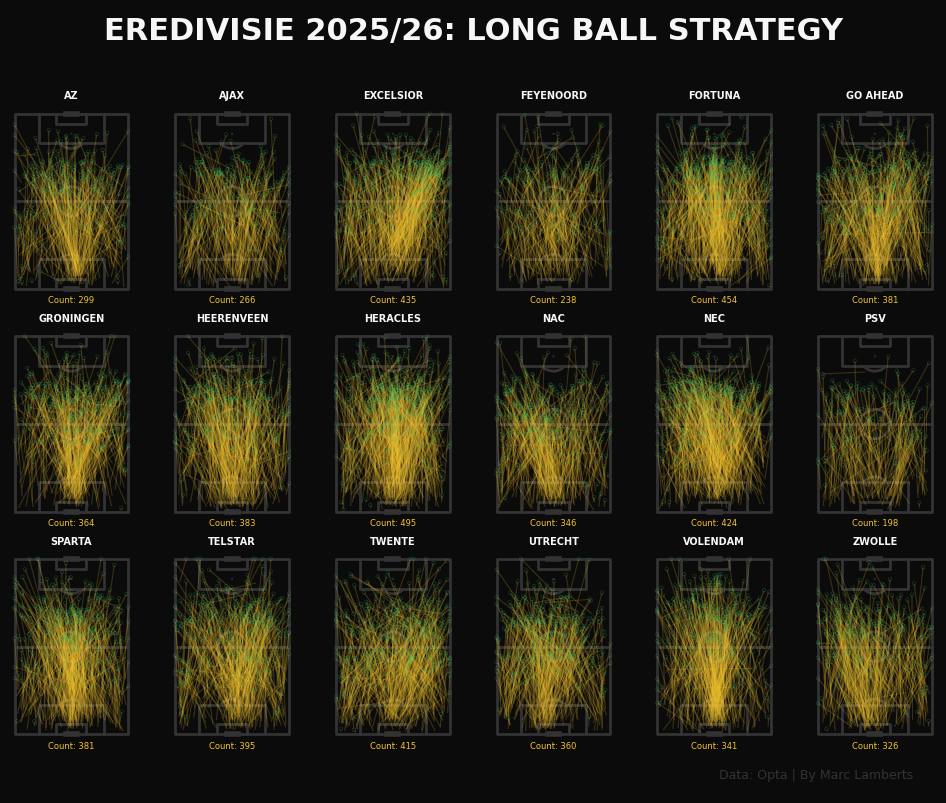

In [12]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from mplsoccer import VerticalPitch

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/')
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')

COLORS = {
    'launch': '#F4C430', 
    'landing': '#2ECC71',
    'bg': '#0B0B0B',
    'lines': '#333333',
    'text': '#F7F7F7'
}

# --- 1. DATA EXTRACTION ---
def get_all_launches(folder_path, mapping_path):
    team_map = {}
    if mapping_path.exists():
        map_df = pd.read_csv(mapping_path)
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    all_rows = []
    for file_path in tqdm(list(folder_path.glob('*.json')), desc="Processing Matches"):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            events = pd.DataFrame(data.get('event', []))
        except: continue

        launches = events[(events['typeId'] == 1) & events['qualifier'].apply(
            lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False
        )].copy()
        
        for idx, row in launches.iterrows():
            ex = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 140), float(row.get('x', 0)) + 35)
            ey = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 141), float(row.get('y', 50)))
            all_rows.append({
                'team': team_map.get(row['contestantId'], row['contestantId']),
                'x': float(row.get('x')), 'y': float(row.get('y')),
                'end_x': float(ex), 'end_y': float(ey)
            })
    return pd.DataFrame(all_rows)

# --- 2. 6x3 GRID VISUALIZATION (SPACED) ---
def plot_6x3_launch_grid_spaced(df):
    teams = sorted(df['team'].unique())
    n_teams = len(teams)
    
    ncols = 6
    nrows = 3

    pitch = VerticalPitch(pitch_type='opta', pitch_color=COLORS['bg'], line_color=COLORS['lines'])
    
    # --- KEY CHANGES FOR SPACE ---
    # We increase 'space' to 0.08 to separate the rows
    # We reduce 'grid_height' to 0.70 to compensate for the extra space
    fig, axs = pitch.grid(nrows=nrows, ncols=ncols, 
                          grid_height=0.70,   
                          grid_width=0.92,
                          space=0.12,         # Vertical and horizontal gap between pitches
                          title_height=0.08, 
                          endnote_height=0.04, 
                          title_space=0.03, 
                          endnote_space=0.02,
                          axis=False)
    fig.set_facecolor(COLORS['bg'])

    for name, ax in zip(teams, axs['pitch'].flat[:n_teams]):
        team_df = df[df['team'] == name]
        
        pitch.arrows(team_df.x, team_df.y, team_df.end_x, team_df.end_y, 
                     color=COLORS['launch'], width=0.8, headwidth=1.5, 
                     headlength=1.5, alpha=0.2, ax=ax)
        
        pitch.scatter(team_df.end_x, team_df.end_y, s=6, 
                      edgecolors=COLORS['landing'], facecolors='none', 
                      linewidth=0.4, alpha=0.3, ax=ax)
        
        # Increased the 'y' coordinate for the labels to pull them away from the lines
        ax.text(50, 108, name.upper(), color=COLORS['text'], 
                fontsize=7, ha='center', fontweight='bold')
        
        ax.text(50, -8, f"Count: {len(team_df)}", color=COLORS['launch'], 
                fontsize=6, ha='center')

    for ax in axs['pitch'].flat[n_teams:]:
        ax.remove()

    # Dashboard Titles
    axs['title'].text(0.5, 0.7, 'EREDIVISIE 2025/26: LONG BALL STRATEGY', color=COLORS['text'],
                      fontsize=22, ha='center', va='center', fontweight='bold')
    
    axs['endnote'].text(0.98, 0.5, 'Data: Opta | By Marc Lamberts', 
                        color=COLORS['lines'], fontsize=9, ha='right', va='center')

    plt.show()

# --- EXECUTION ---
if __name__ == "__main__":
    launch_df = get_all_launches(FOLDER_PATH, MAPPING_FILE)
    if not launch_df.empty:
        plot_6x3_launch_grid_spaced(launch_df)

Processing Matches: 100%|██████████| 143/143 [00:08<00:00, 17.15it/s]


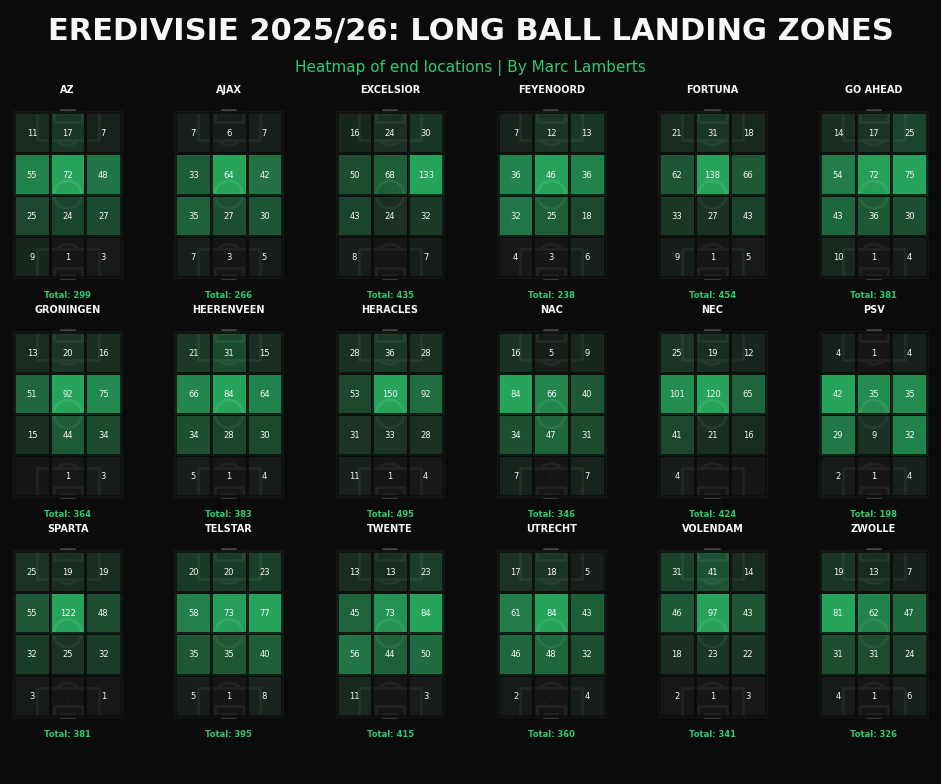

In [16]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from mplsoccer import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap

# --- CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/')
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')

COLORS = {
    'bg': '#0B0B0B',
    'lines': '#444444',
    'text': '#F7F7F7',
    'bin_low': '#1A1A1A',
    'bin_high': '#2ECC71' # Emerald for high density
}

# Create a custom colormap for the bins
cmap = LinearSegmentedColormap.from_list('launch_cmap', [COLORS['bin_low'], COLORS['bin_high']])

# --- 1. DATA EXTRACTION ---
def get_all_launches(folder_path, mapping_path):
    team_map = {}
    if mapping_path.exists():
        map_df = pd.read_csv(mapping_path)
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    all_rows = []
    for file_path in tqdm(list(folder_path.glob('*.json')), desc="Processing Matches"):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            events = pd.DataFrame(data.get('event', []))
        except: continue

        launches = events[(events['typeId'] == 1) & events['qualifier'].apply(
            lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False
        )].copy()
        
        for idx, row in launches.iterrows():
            ex = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 140), float(row.get('x', 0)) + 35)
            ey = next((q.get('value') for q in row['qualifier'] if q.get('qualifierId') == 141), float(row.get('y', 50)))
            all_rows.append({
                'team': team_map.get(row['contestantId'], row['contestantId']),
                'x': float(row.get('x')), 'y': float(row.get('y')),
                'end_x': float(ex), 'end_y': float(ey)
            })
    return pd.DataFrame(all_rows)

# --- 2. 6x3 HEATMAP GRID VISUALIZATION ---
def plot_6x3_launch_heatmap(df):
    teams = sorted(df['team'].unique())
    n_teams = len(teams)
    ncols, nrows = 6, 3

    pitch = VerticalPitch(pitch_type='opta', pitch_color=COLORS['bg'], line_color=COLORS['lines'])
    
    # Balanced spacing to prevent text overlap
    fig, axs = pitch.grid(nrows=nrows, ncols=ncols, 
                          grid_height=0.68,   
                          grid_width=0.92,
                          space=0.15, # Increased space for labels
                          title_height=0.08, 
                          endnote_height=0.04, 
                          title_space=0.03, 
                          endnote_space=0.02,
                          axis=False)
    fig.set_facecolor(COLORS['bg'])

    for name, ax in zip(teams, axs['pitch'].flat[:n_teams]):
        team_df = df[df['team'] == name]
        
        # 1. Calculate Bin Statistics (using landing positions: end_x, end_y)
        # 4 rows, 3 columns per small pitch for readability
        bin_stats = pitch.bin_statistic(team_df.end_x, team_df.end_y, statistic='count', bins=(4, 3))
        
        # 2. Plot the Heatmap
        pitch.heatmap(bin_stats, ax=ax, cmap=cmap, edgecolor=COLORS['bg'], alpha=0.8)
        
        # 3. Add Count Labels in Bins
        # Only show labels where count > 0 to avoid clutter
        pitch.label_heatmap(bin_stats, color=COLORS['text'], fontsize=6, 
                            ax=ax, ha='center', va='center', str_format='{:.0f}',
                            exclude_zeros=True)
        
        # 4. Add Team Names and Total Count
        ax.text(50, 112, name.upper(), color=COLORS['text'], 
                fontsize=7, ha='center', fontweight='bold')
        ax.text(50, -12, f"Total: {len(team_df)}", color=COLORS['bin_high'], 
                fontsize=6, ha='center', fontweight='bold')

    # Remove unused axes
    for ax in axs['pitch'].flat[n_teams:]:
        ax.remove()

    axs['title'].text(0.5, 0.7, 'EREDIVISIE 2025/26: LONG BALL LANDING ZONES', color=COLORS['text'],
                      fontsize=22, ha='center', va='center', fontweight='bold')
    axs['title'].text(0.5, 0.2, 'Heatmap of end locations | By Marc Lamberts', color=COLORS['bin_high'],
                      fontsize=11, ha='center', va='center')

    plt.show()

# --- EXECUTION ---
if __name__ == "__main__":
    launch_df = get_all_launches(FOLDER_PATH, MAPPING_FILE)
    if not launch_df.empty:
        plot_6x3_launch_heatmap(launch_df)

In [18]:
import pandas as pd
import json
import os
import numpy as np
from datetime import timedelta
from pathlib import Path
from sklearn.linear_model import LogisticRegression

# ==========================================
# CONFIGURATION
# ==========================================
# Update these paths to match your local folders
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/') 
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')

DELTA_T = 5.0  # Time window for second ball retention (seconds)
CHAOS_WINDOW = 2.0  # Time window for chaos score (seconds)
DENSITY_WINDOW = 3.0  # Lookback window for local density (seconds)

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def calculate_pass_length(row):
    """Calculates pass distance in meters (approx based on 105x68 pitch)."""
    try:
        dx = (row['endX'] - row['x']) * 1.05
        dy = (row['endY'] - row['y']) * 0.68
        return np.sqrt(dx**2 + dy**2)
    except:
        return 0

def get_event_density(events, timestamp, team_id):
    """Calculates net action density in the 3 seconds prior to a pass."""
    start = timestamp - timedelta(seconds=DENSITY_WINDOW)
    pre_window = events[(events['timeStamp'] >= start) & (events['timeStamp'] < timestamp)]
    
    team_actions = len(pre_window[pre_window['contestantId'] == team_id])
    opp_actions = len(pre_window[pre_window['contestantId'] != team_id])
    
    return team_actions - opp_actions

def process_match_file(file_path):
    """Extracts long ball events and their features/outcomes from a single file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Skipping {file_path.name}: {e}")
        return pd.DataFrame()
    
    events_list = data.get('event', [])
    if not events_list: return pd.DataFrame()
        
    events = pd.DataFrame(events_list)
    events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
    
    # Controlled actions (possession-defining events)
    # 1=Pass, 3=Take On, 4=Foul Won, 7=Tackle, 8=Interception, 10=Save, 13-16=Shots, 49=Recovery
    controlled_ids = [1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49]
    
    # Filter for Long Balls (Qualifier 1)
    long_balls = events[
        (events['typeId'] == 1) & 
        (events['qualifier'].apply(lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False))
    ].copy()

    rows = []
    for _, lb in long_balls.iterrows():
        start_time = lb['timeStamp']
        end_time = start_time + timedelta(seconds=DELTA_T)
        
        # 1. ACTUAL OUTCOME (SBRP-E Label)
        window = events[(events['timeStamp'] > start_time) & (events['timeStamp'] <= end_time)].sort_values('timeStamp')
        outcome = 0
        for _, row in window.iterrows():
            if row['typeId'] in controlled_ids:
                outcome = 1 if row['contestantId'] == lb['contestantId'] else 0
                break
                
        # 2. FEATURE: CHAOS SCORE
        chaos = len(events[(events['timeStamp'] >= start_time) & (events['timeStamp'] <= start_time + timedelta(seconds=CHAOS_WINDOW))])
        
        # 3. FEATURE: LOCAL DENSITY
        density = get_event_density(events, start_time, lb['contestantId'])
        
        # 4. FEATURE: LANDING GEOMETRY
        # Opta uses x/y for origin. We use endX/endY for landing context.
        lx = lb.get('endX', lb['x'])
        ly = lb.get('endY', lb['y'])
        
        # 5. FEATURE: PASS LENGTH
        length = calculate_pass_length(lb)
        
        rows.append({
            'team_id': lb['contestantId'],
            'outcome': outcome,
            'chaos': chaos,
            'density': density,
            'land_x': lx,
            'land_y': ly,
            'length': length
        })
        
    return pd.DataFrame(rows)

# ==========================================
# MAIN EXECUTION
# ==========================================

def run_xsbr_model():
    # A. Build Team Mapping
    team_map = {}
    if MAPPING_FILE.exists():
        map_df = pd.read_csv(MAPPING_FILE)
        # Search for contestant ID/Name pairs in standard Opta CSV columns
        for i in range(2):
            id_col, name_col = f"matchInfo/contestant/{i}/id", f"matchInfo/contestant/{i}/shortName"
            if id_col in map_df.columns:
                team_map.update(dict(zip(map_df[id_col], map_df[name_col])))

    # B. Aggregate all data for training
    print(f"Scanning folder: {FOLDER_PATH}...")
    all_data_list = []
    for json_file in FOLDER_PATH.glob('*.json'):
        df_match = process_match_file(json_file)
        if not df_match.empty:
            all_data_list.append(df_match)
            
    if not all_data_list:
        print("Error: No data found. Check your folder path and JSON structure.")
        return
        
    master_df = pd.concat(all_data_list).dropna()
    print(f"Total long balls extracted: {len(master_df)}")

    # C. Train the Expected Model (Logistic Regression)
    # Features that define the difficulty of retaining the second ball
    feature_cols = ['chaos', 'density', 'land_x', 'land_y', 'length']
    X = master_df[feature_cols]
    y = master_df['outcome']
    
    if len(master_df) < 20:
        print("Warning: Sample size is very small. xSBR results may be volatile.")
    
    clf = LogisticRegression()
    clf.fit(X, y)
    
    # Generate the Expected Probability (xSBR)
    master_df['xSBR'] = clf.predict_proba(X)[:, 1]
    
    # Calculate Value Added (Actual - Expected)
    master_df['SBR_Added'] = master_df['outcome'] - master_df['xSBR']
    
    # D. Aggregate by Team
    master_df['team_name'] = master_df['team_id'].map(team_map).fillna(master_df['team_id'])
    
    summary = master_df.groupby('team_name').agg(
        long_balls=('outcome', 'count'),
        actual_retained=('outcome', 'sum'),
        expected_retained=('xSBR', 'sum'),
        total_value_added=('SBR_Added', 'sum'),
        avg_chaos=('chaos', 'mean')
    ).reset_index()
    
    # Final Metrics
    summary['SBR_Success_Rate'] = (summary['actual_retained'] / summary['long_balls']) * 100
    summary['Performance_Index'] = summary['actual_retained'] / summary['expected_retained']
    
    # Sort and Display
    summary = summary.sort_values('total_value_added', ascending=False)
    
    print("\n--- EXPECTED SECOND BALL RETENTION (xSBR) SUMMARY ---")
    print(summary[['team_name', 'long_balls', 'SBR_Success_Rate', 'total_value_added', 'Performance_Index']])
    
    # Save results
    summary.to_excel('/Users/user/Models/xSBR/xsbr_full_analysis.xlsx', index=False)
    print("\nFull analysis saved to 'xsbr_full_analysis.xlsx'")

if __name__ == "__main__":
    run_xsbr_model()

Scanning folder: /Users/user/XG/Eredivisie 2025-2026/DONE...
Total long balls extracted: 6501

--- EXPECTED SECOND BALL RETENTION (xSBR) SUMMARY ---
     team_name  long_balls  SBR_Success_Rate  total_value_added  \
15     Utrecht         360         31.388889          33.812731   
12      Sparta         381         29.658793          33.032499   
2    Excelsior         435         25.057471          15.584889   
14      Twente         415         25.060241          14.473632   
9          NAC         346         24.566474          10.984733   
3    Feyenoord         238         25.630252          10.072646   
0           AZ         299         23.076923           5.396945   
1         Ajax         266         22.932331           4.118742   
8     Heracles         495         21.616162           1.476586   
11         PSV         198         18.181818          -6.092349   
10         NEC         424         18.632075          -9.507047   
5     Go Ahead         381         18.372703   

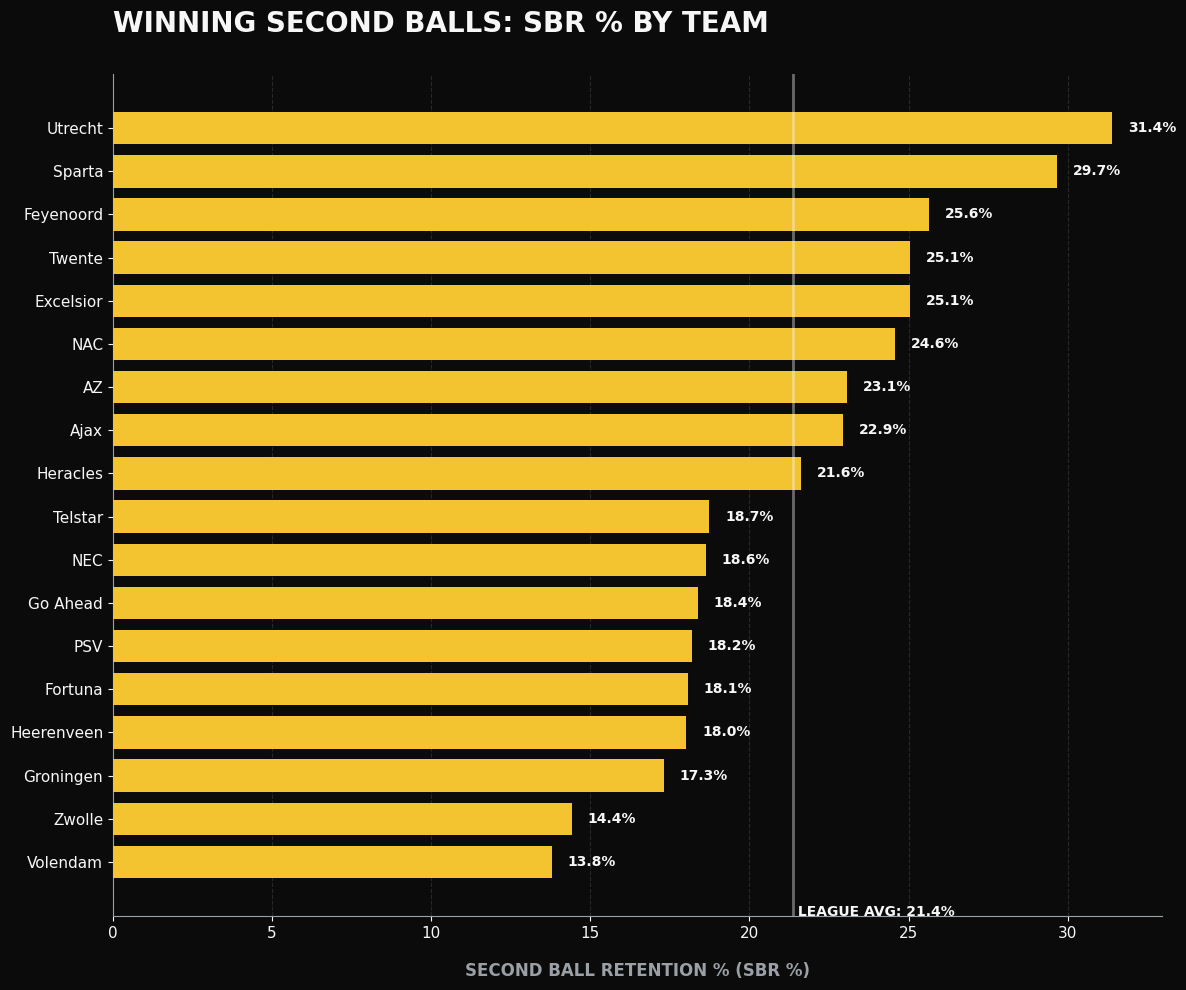

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# --- 1. CONFIGURATION & COLORS ---
COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71',
}

# --- 2. LOAD DATA ---
FILE_PATH = r'/Users/user/Models/xSBR/xsbr_full_analysis.xlsx'
df = pd.read_excel(FILE_PATH)

# Prepare for plotting: Sort by success rate and rename for clarity
plot_df = df.sort_values('SBR_Success_Rate', ascending=True).copy()
plot_df = plot_df.rename(columns={'SBR_Success_Rate': 'SBR %'})

# --- 3. VISUALIZATION ---
fig, ax = plt.subplots(figsize=(12, 10))
fig.set_facecolor(COLORS['black'])
ax.set_facecolor(COLORS['black'])

# Create horizontal bars
bars = ax.barh(plot_df['team_name'], plot_df['SBR %'], 
              color=COLORS['yellow'], height=0.75, zorder=3)

# Style axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(COLORS['grey'])
ax.spines['left'].set_color(COLORS['grey'])

ax.tick_params(axis='x', colors=COLORS['white'], labelsize=11)
ax.tick_params(axis='y', colors=COLORS['white'], labelsize=11)

# Labels & Title
ax.set_xlabel('SECOND BALL RETENTION % (SBR %)', color=COLORS['grey'], 
              fontsize=12, fontweight='bold', labelpad=15)
ax.set_title('WINNING SECOND BALLS: SBR % BY TEAM', color=COLORS['white'], 
             fontsize=20, pad=30, fontweight='bold', loc='left')

# Add Grid
ax.grid(axis='x', color=COLORS['grey'], linestyle='--', alpha=0.2, zorder=0)

# --- 4. DATA LABELS ---
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', 
            va='center', color=COLORS['white'], fontweight='bold', fontsize=10)

# --- 5. LEAGUE AVERAGE LINE ---
avg_sbr = plot_df['SBR %'].mean()
plt.axvline(avg_sbr, color=COLORS['white'], linestyle='-', alpha=0.4, lw=2, zorder=4)
ax.text(avg_sbr, -1, f' LEAGUE AVG: {avg_sbr:.1f}%', color=COLORS['white'], 
        fontsize=10, fontweight='bold', va='top')

plt.tight_layout()
plt.show()

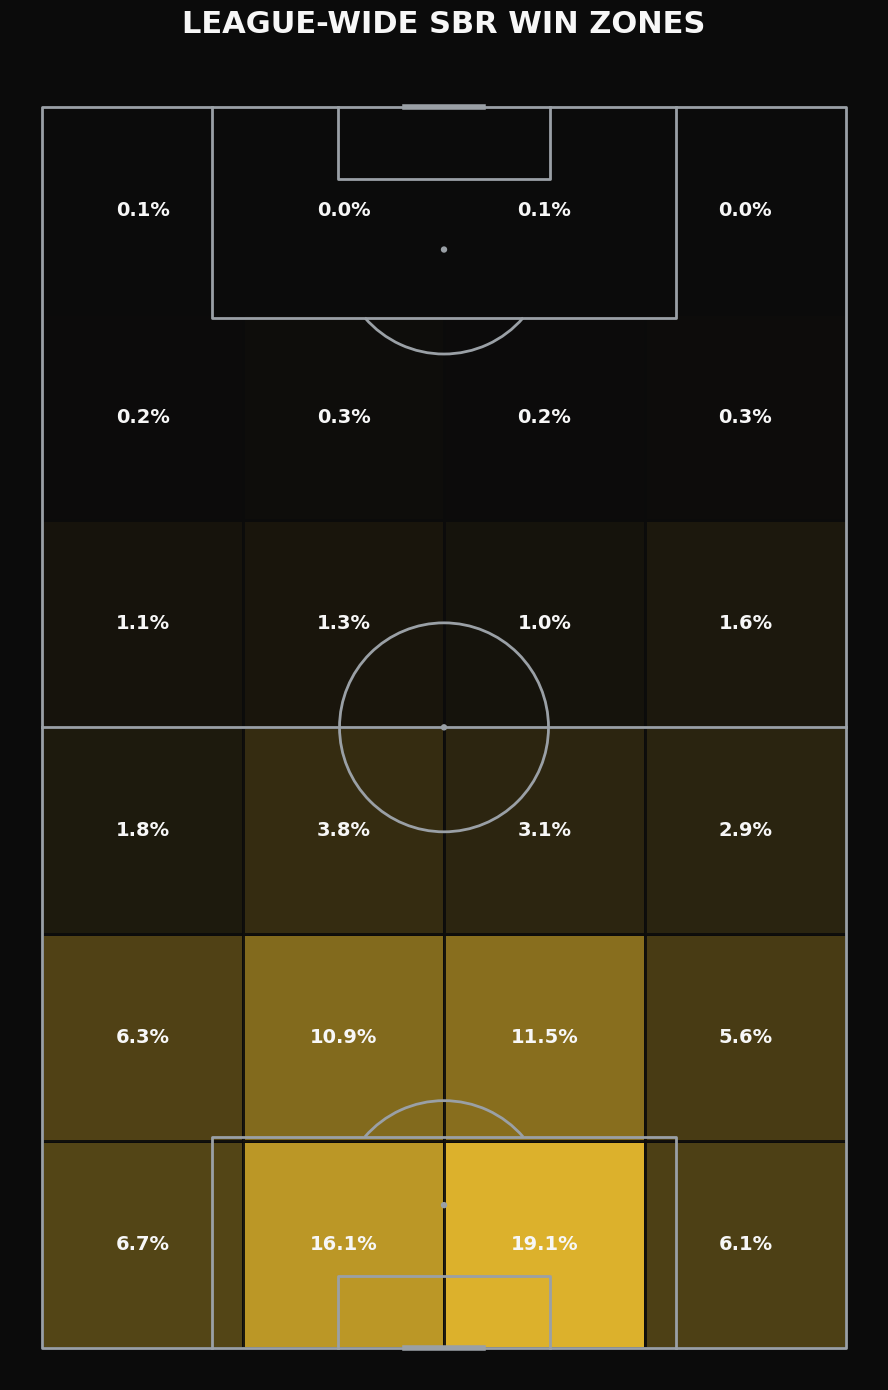

In [30]:
import pandas as pd
import numpy as np
import json
from datetime import timedelta
from pathlib import Path
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap

# --- 1. CONFIGURATION & COLORS ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/') 
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')
COLORS = {'yellow': '#F4C430', 'black': '#0B0B0B', 'white': '#F7F7F7', 'grey': '#9AA0A6'}
custom_cmap = LinearSegmentedColormap.from_list('pro_heat', [COLORS['black'], COLORS['yellow']])

# --- 2. EXTRACTION & MODELING ---
def process_match_file(file_path):
    try:
        with open(file_path, 'r') as f: data = json.load(f)
        events = pd.DataFrame(data.get('event', []))
        events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
    except: return pd.DataFrame()
    
    controlled_ids = [1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49]
    long_balls = events[(events['typeId'] == 1) & (events['qualifier'].apply(
        lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False))].copy()

    rows = []
    for _, lb in long_balls.iterrows():
        start_time = lb['timeStamp']
        window = events[(events['timeStamp'] > start_time) & (events['timeStamp'] <= start_time + timedelta(seconds=5.0))]
        outcome = 1 if any((window['typeId'].isin(controlled_ids)) & (window['contestantId'] == lb['contestantId'])) else 0
        rows.append({'outcome': outcome, 'land_x': lb.get('endX', lb['x']), 'land_y': lb.get('endY', lb['y'])})
    return pd.DataFrame(rows)

# --- 3. MAIN EXECUTION ---
all_data = pd.concat([process_match_file(f) for f in FOLDER_PATH.glob('*.json')]).dropna()
wins_df = all_data[all_data['outcome'] == 1].copy()

# PITCH SETUP (6x4 Grid)
pitch = VerticalPitch(pitch_type='opta', line_color=COLORS['grey'], pitch_color=COLORS['black'], line_zorder=3)
fig, ax = pitch.draw(figsize=(10, 14))
fig.set_facecolor(COLORS['black'])

# THE FIX: First argument is the length-axis (x), second is the width-axis (y)
# bins=(6, 4) creates 6 vertical rows and 4 horizontal columns
bin_stat = pitch.bin_statistic(wins_df.land_x, wins_df.land_y, statistic='count', bins=(6, 4))
bin_stat['statistic'] = (bin_stat['statistic'] / len(wins_df)) * 100

# Plotting Heatmap & Labels
pitch.heatmap(bin_stat, ax=ax, cmap=custom_cmap, edgecolors=COLORS['black'], alpha=0.9)
pitch.label_heatmap(bin_stat, color=COLORS['white'], fontsize=14, fontweight='bold', str_format='{:.1f}%', ax=ax)

plt.title("LEAGUE-WIDE SBR WIN ZONES", color=COLORS['white'], fontsize=22, pad=30, fontweight='bold')
plt.show()

Scanning for Defensive-to-Attacking vertical launches...
Extracted 3636 targeted events.


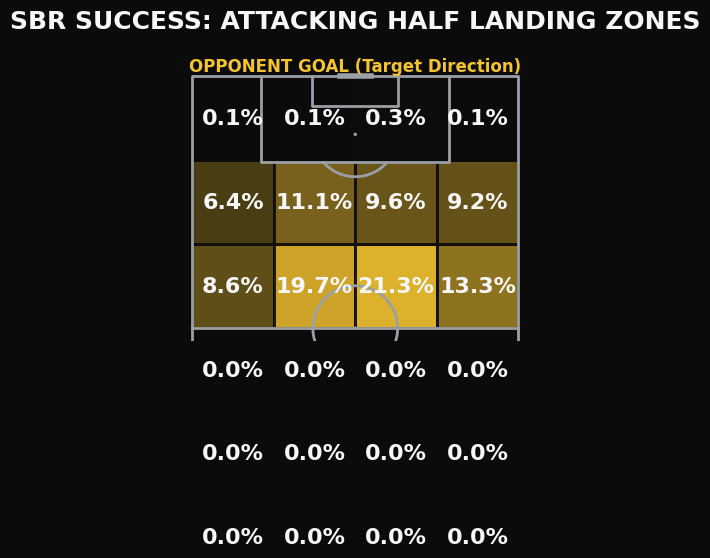

In [38]:
import pandas as pd
import json
import numpy as np
from datetime import timedelta
from pathlib import Path
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap

# --- 1. CONFIGURATION ---
FOLDER_PATH = Path(r'/Users/user/XG/Eredivisie 2025-2026/DONE/') 
MAPPING_FILE = Path(r'/Users/user/XG/Eredivisie 2025-2026 Matches.csv')

COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
}
custom_cmap = LinearSegmentedColormap.from_list('pro_heat', [COLORS['black'], COLORS['yellow']])

# --- 2. DATA EXTRACTION ---
def process_match_file(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        events = pd.DataFrame(data.get('event', []))
        events['timeStamp'] = pd.to_datetime(events['timeStamp'], format='ISO8601')
    except: return pd.DataFrame()
    
    controlled_ids = [1, 3, 4, 7, 8, 10, 13, 14, 15, 16, 49]
    
    # Filter for Launches (Opta Qualifier 157)
    launches = events[(events['typeId'] == 1) & (events['qualifier'].apply(
        lambda x: any(q.get('qualifierId') == 157 for q in x) if isinstance(x, list) else False))].copy()

    rows = []
    for idx, lb in launches.iterrows():
        start_x = float(lb.get('x', 0))
        start_y = float(lb.get('y', 0))
        
        # Determine landing spot via Qualifiers 140/141 or fallback to endX
        land_x = next((float(q.get('value')) for q in lb['qualifier'] if q.get('qualifierId') == 140), lb.get('endX', start_x + 30))
        land_y = next((float(q.get('value')) for q in lb['qualifier'] if q.get('qualifierId') == 141), lb.get('endY', start_y))

        # --- CRITERIA: Start Def 3rd (<33.3) and End in Attacking Half (>50) ---
        if start_x < 33.3 and land_x > 50:
            start_time = lb['timeStamp']
            # Window check for possession retention
            window = events.iloc[idx + 1 : idx + 12].copy()
            window = window[(pd.to_datetime(window['timeStamp']) - start_time).dt.total_seconds() <= 5.0]
            
            outcome = 0
            if not window.empty:
                for _, row in window.iterrows():
                    if row['typeId'] in controlled_ids:
                        outcome = 1 if row['contestantId'] == lb['contestantId'] else 0
                        break
            
            rows.append({
                'outcome': outcome,
                'land_x': float(land_x), 
                'land_y': float(land_y),
                'chaos': len(window)
            })
    return pd.DataFrame(rows)

# --- 3. EXECUTION ---
print("Scanning for Defensive-to-Attacking vertical launches...")
all_match_data = []
for f in FOLDER_PATH.glob('*.json'):
    df_m = process_match_file(f)
    if not df_m.empty: all_match_data.append(df_m)

if not all_match_data:
    print("No data found matching tactical criteria.")
else:
    all_data = pd.concat(all_match_data).dropna()
    print(f"Extracted {len(all_data)} targeted events.")

    # A. Modeling (Basic xSBR check)
    X = all_data[['land_x', 'land_y', 'chaos']]
    y = all_data['outcome']
    model = LogisticRegression().fit(X, y)
    all_data['xSBR'] = model.predict_proba(X)[:, 1]

    # B. Visualization (Half Pitch, Attacking orientation)
    wins_df = all_data[all_data['outcome'] == 1].copy()
    
    # half=True zooms into the attacking half (x=50 to x=100)
    pitch = VerticalPitch(pitch_type='opta', half=True, 
                          line_color=COLORS['grey'], pitch_color=COLORS['black'], 
                          line_zorder=3)
    
    fig, ax = pitch.draw(figsize=(10, 8))
    fig.set_facecolor(COLORS['black'])

    # Bins: (3 rows vertically for the half pitch, 4 columns horizontally)
    # land_x is the vertical axis. Opta x=100 will be at the top by default in VerticalPitch.
    bin_stat = pitch.bin_statistic(wins_df.land_x, wins_df.land_y, statistic='count', bins=(6, 4))
    
    # Percentage relative to successful targeted launches
    total_wins = len(wins_df)
    bin_stat['statistic'] = (bin_stat['statistic'] / total_wins) * 100

    # Draw Heatmap
    heatmap = pitch.heatmap(bin_stat, ax=ax, cmap=custom_cmap, edgecolors=COLORS['black'], alpha=0.9)
    
    # Label each zone
    pitch.label_heatmap(bin_stat, color=COLORS['white'], fontsize=16, fontweight='bold', 
                        str_format='{:.1f}%', ax=ax)

    plt.title("SBR SUCCESS: ATTACKING HALF LANDING ZONES", color=COLORS['white'], 
              fontsize=18, fontweight='bold', pad=25)
    
    ax.text(50, 101, "OPPONENT GOAL (Target Direction)", color=COLORS['yellow'], 
            ha='center', fontsize=12, fontweight='bold')

    plt.show()